In [1]:
from __future__ import unicode_literals
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import sklearn

In [2]:
pd.set_option("display.max_colwidth", 100)

In [3]:
df = pd.read_csv('aggregation.csv')
df.head()

,text,retweet_count,favorite_count,username,userdesc,verified,followers,created_at,has_urls,has_mentions,high_response
0,They are starting to get more and more desperate...\nThis shows that we’re winning. https://t.co...,24298,168648,GretaThunberg,17 year old climate and environmental activist with Asperger’s #climatestrike #fridaysforfuture...,True,4079169,2020-02-29 15:26:10,True,False,True
1,I do not believe we will defeat Donald Trump with a candidate like Joe Biden who supported the I...,18592,77895,BernieSanders,U.S. Senator from Vermont and candidate for President of the United States.,True,10951634,2020-03-02 20:30:56,False,False,True
2,Indigenous rights = Climate justice\n#WetsuwetenStrong #KeepItInTheGround https://t.co/1kYNumyoQT,4609,21488,GretaThunberg,17 year old climate and environmental activist with Asperger’s #climatestrike #fridaysforfuture...,True,4086646,2020-02-08 13:36:48,True,False,True
3,"Stop running away from your problem. Run into your problem. It will suck. Really suck. But, wh...",2739,16317,pulte,"The Philanthropist. Inventor of Twitter Philanthropy. Giving Money, Food, and Rent To People In ...",True,2059165,2020-02-29 21:19:22,True,False,True
4,Support the Wet’suwet’en Nation and the pipeline protests happening now in Canada! #WetsuwenStro...,2972,10035,GretaThunberg,17 year old climate and environmental activist with Asperger’s #climatestrike #fridaysforfuture...,True,4091979,2020-02-18 10:13:02,True,False,True


In [4]:
from sklearn.pipeline import Pipeline

# Tutorials:
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics

In [5]:
tweet_corpus = list(df['text'])

In [6]:
# Remove URL junk
url_pattern = re.compile("http[^\s]+", re.I)

for i in range(len(tweet_corpus)):
    tweet_corpus[i] = url_pattern.sub('', tweet_corpus[i])

In [7]:
print(tweet_corpus[:5])

['They are starting to get more and more desperate...\nThis shows that we’re winning. ', 'I do not believe we will defeat Donald Trump with a candidate like Joe Biden who supported the Iraq War. ', 'Indigenous rights = Climate justice\n#WetsuwetenStrong #KeepItInTheGround ', 'Stop running away from your problem. Run into your problem.  It will suck.  Really suck. But, when you pop out the… ', 'Support the Wet’suwet’en Nation and the pipeline protests happening now in Canada! #WetsuwenStrong  ']


In [8]:
hashtag_pattern = re.compile("#[^\s]+", re.I)

for i in range(20):
    matches = hashtag_pattern.findall(tweet_corpus[i])
    if matches:
        print(matches)

['#WetsuwetenStrong', '#KeepItInTheGround']
['#WetsuwenStrong']
['#CoastalGasLink']
['#Greece', '#Athens', '#EU']
['#Wetsuweten']
['#WetsuwetenSolidarity']


In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

add_stop_words = ['wetsuweten', 'wet', 'suwet', 'en',
                  'wetsuwetenstrong', 'wetsuwetensolidarity', 'shutdowncanada',
                    'bc', 'british', 'columbia', 'canada', 'indigenous', 'pipeline']

custom_stop_words = set(ENGLISH_STOP_WORDS).union(set(add_stop_words))

In [10]:
# Text frequency*Inverse document frequency matrix
# max_df: ignore terms with frequency higher than
# lowercase = True by default
tf_vect = TfidfVectorizer(strip_accents='unicode',
                          analyzer='word',
                          stop_words=custom_stop_words,
#                           max_df=0.5,
                          ngram_range=(1,2))
tf_matrix = tf_vect.fit_transform(tweet_corpus)

In [12]:
terms = tf_vect.get_feature_names()
print("n-grams:", len(terms))

n-grams: 32371


In [15]:
tf_matrix.shape

(4219, 32371)

In [17]:
# Dimensionality reduction for latent semantic analysis
svd = TruncatedSVD(n_components=100) # Recommended param for TfIdf matrix
normalizer = Normalizer(copy=False)
lsa = Pipeline([
    ('truncated_SVD', svd), 
    ('normalizer', normalizer)
    ])

In [18]:
tf_matrix = lsa.fit_transform(tf_matrix)

In [19]:
for n_clusters in range(2,9):
    km_comp = KMeans(n_clusters=n_clusters, random_state=0)
    km_comp.fit(tf_matrix)
    print("%d\t Silhouette coefficient: %0.3f" % (n_clusters,
                                              metrics.silhouette_score(tf_matrix, km_comp.labels_)))

2	 Silhouette coefficient: 0.031
3	 Silhouette coefficient: 0.033
4	 Silhouette coefficient: 0.039
5	 Silhouette coefficient: 0.043
6	 Silhouette coefficient: 0.046
7	 Silhouette coefficient: 0.055
8	 Silhouette coefficient: 0.058


In [27]:
km = KMeans(7) # default: n_clusters=8, max_iter=300, n_init=10
km.fit(tf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [28]:
# with SVD
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
# without SVD
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(km.n_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :20]:
            print('   %s' % terms[ind], end='')
        print('\n')

Cluster 0:   solidarity   youth   iy4wetsuweten   legislature   arrested   solidarity nation   youth arrested   students   today   nation   stand   statement   vicpdcanada   occupying   action   scottfraserndp   fraser   inside   london   outside

Cluster 1:   amp   pagan   sign   heathen   polytheist   amp polytheist   polytheist statement   solidarity amp   federal   statement solidarity   pagan amp   amp tyendinaga   amp heathen   heathen amp   need   cgl   video   action   news   jjhorgan

Cluster 2:   cdnpoli   bcpoli   cdnpoli bcpoli   bcpoli cdnpoli   trudeau   blockades   onpoli   cbcalerts   stop   aboriginal   media   sure   aboriginal cdnpoli   work   bcpoli onpoli   breaking   cdnpoli prayers   read cdnpoli   prayers   conservatives

Cluster 3:   like   just   government   blockades   know   new   support   today   rcmp   media   rights   canadian   coastalgaslink   great   time   trudeau   did   don   agreement   nation

Cluster 4:   people   amp   stop   right   solidarit

In [29]:
labels = km.labels_.tolist() # [0,1,2...]

In [30]:
km_df_cols = {'user': df['username'], 'text': df['text'], 
              'label': labels}
km_df = pd.DataFrame(km_df_cols)
km_df[:20]

,user,text,label
0,GretaThunberg,They are starting to get more and more desperate...\nThis shows that we’re winning. https://t.co...,3
1,BernieSanders,I do not believe we will defeat Donald Trump with a candidate like Joe Biden who supported the I...,3
2,GretaThunberg,Indigenous rights = Climate justice\n#WetsuwetenStrong #KeepItInTheGround https://t.co/1kYNumyoQT,3
3,pulte,"Stop running away from your problem. Run into your problem. It will suck. Really suck. But, wh...",3
4,GretaThunberg,Support the Wet’suwet’en Nation and the pipeline protests happening now in Canada! #WetsuwenStro...,3
5,GretaThunberg,Om Friday we strike in Brussels! \nSee you at Central Station 14:00 along with representatives f...,3
6,CanadaAction,Wet’suwet’en Nation member Shirley Wilson supports #CoastalGasLink \n\n“I don’t agree with the p...,3
7,CanadaAction,"This is powerful. Rita George, Wet'suwet'en Matriarch &amp; Hereditary Subchief.\n\n“What’s happ...",1
8,leahstokes,Fellow faculty: Just wanted to share what I've done to help students out with the coronavirus in...,3
9,prageru,THIS is the result of socialism. https://t.co/O0QMPvLsgh,3


In [31]:
grouped = km_df.groupby(km_df['label'])
grouped.size() # tweets in each group

label
0     337
1     188
2     176
3    2742
4     220
5     297
6     259
dtype: int64

In [32]:
non_ascii_pattern = re.compile("[^\u0000-\u2300]")
# ellipsis: "\u2026"; currency symbols later

for i in range(200):
    if non_ascii_pattern.search(tweet_corpus[i]):
        print((non_ascii_pattern.findall(tweet_corpus[i])[0]))

👉
👉
✊
❌
✊
🔥


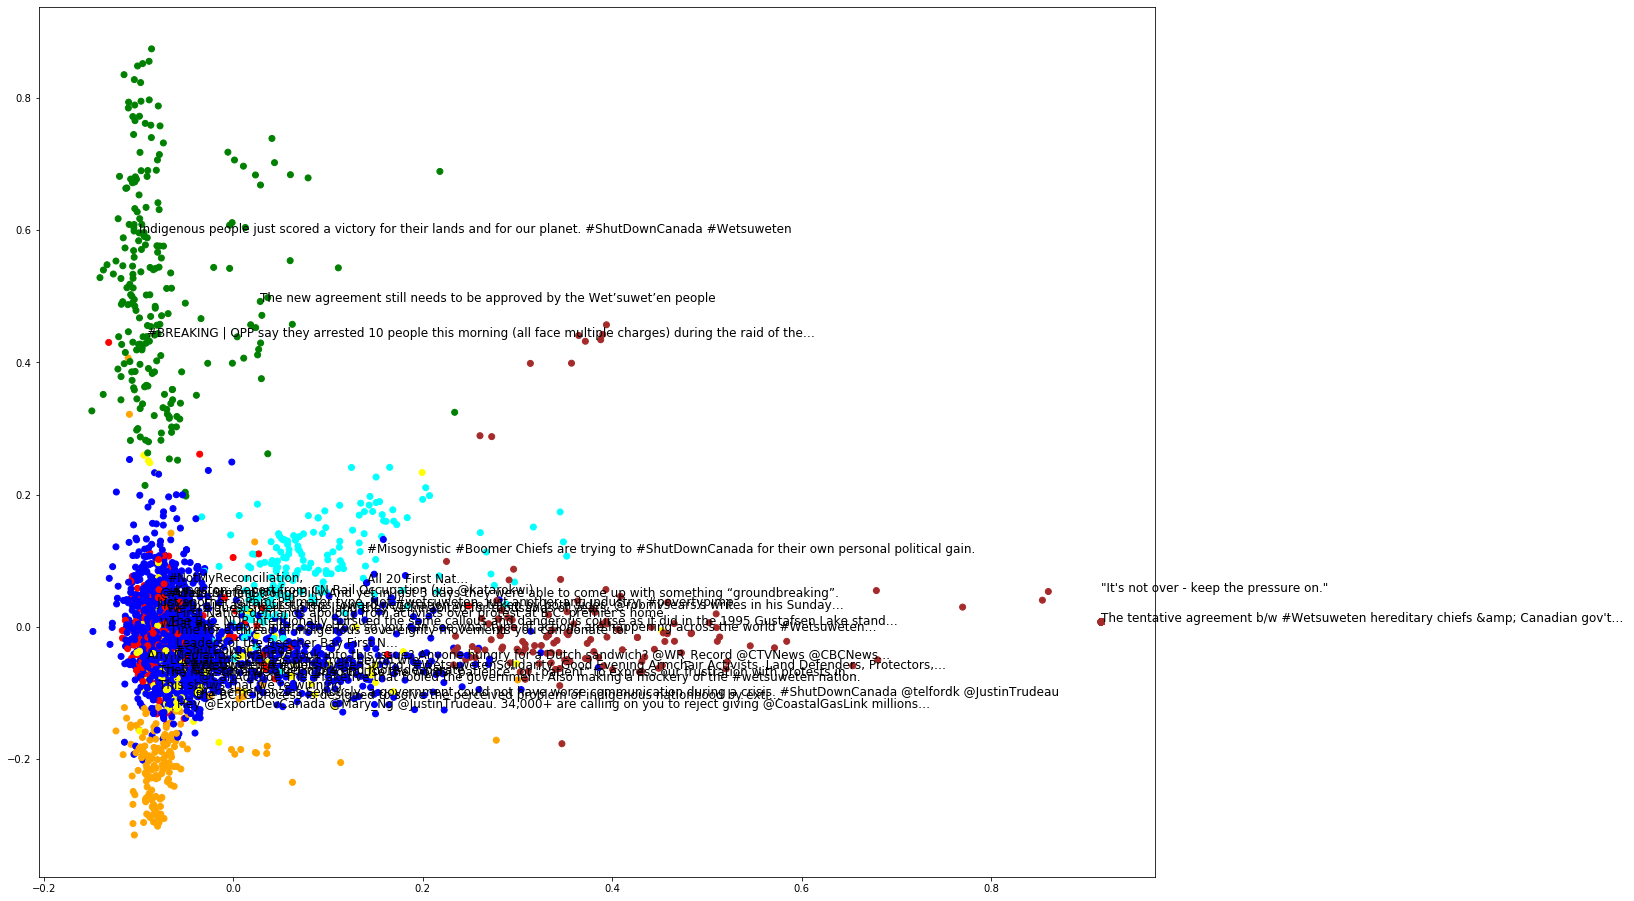

In [33]:
pca = PCA(n_components=2) # Principal Component Analysis: reduce to 2D space
                          # only for sparse input, i.e. SVD
scatter_plot_points = pca.fit_transform(tf_matrix)

colors = ["red", "cyan", "orange", "blue", "green", "yellow", "brown"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,16))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in km.labels_])

for i, txt in enumerate(tweet_corpus):
    if i % 200 != 0:
        continue
    if non_ascii_pattern.search(txt):
        txt = non_ascii_pattern.sub('', txt)
    ax.annotate(txt, xy=(x_axis[i], y_axis[i]), size=12)

In [ ]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tf_matrix, km.labels_))